#### Laod packages

In [2]:
import sys
import os
import importlib
import matplotlib
import nibabel as nib
import numpy as np
# Get the absolute path of the parent directory
project_path = os.path.abspath("..")  
sys.path.append(project_path)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pyMEAL
import tensorflow as tf
from tensorflow import keras
import pyMEAL.traditional_augmentation as TA
importlib.reload(TA)

import pyMEAL.basics as bcs
import pyMEAL.plotting as plot
import pyMEAL.utils as utils

In [3]:
####
# Environment configuration
bcs.configure_environment("2,1")
bcs.set_random_seed(42)

In [4]:
# Configuration at the top of your script
LOG_DIR = "./save_log/" 
MODEL_DIR = "./saved_models/"
os.makedirs(LOG_DIR, exist_ok=True)  # Creates directory if it doesn't exist
os.makedirs(MODEL_DIR, exist_ok=True)  # Creates directory if it doesn't exist

In [5]:
# Dataset and model params
INPUT_SHAPE = (128, 128, 64, 1)
TARGET_SHAPE = INPUT_SHAPE[:3]
BATCH_SIZE = 1

#### Load data

In [6]:
DATA_DIR = os.path.abspath("../CTScan data/processed_data")

TRAIN_PATHS = {
    "input": os.path.join(DATA_DIR, "proceed_CT", "tr"),
    "target": os.path.join(DATA_DIR, "proceed_T1", "tr")
}

VAL_PATHS = {
    "input": os.path.join(DATA_DIR, "proceed_CT", "te"),
    "target": os.path.join(DATA_DIR, "proceed_T1", "te")
}

#### Training

In [7]:
# --- Training ---
def main():
    train_ds = TA.create_dataset(TRAIN_PATHS["input"], TRAIN_PATHS["target"])
    val_ds = TA.create_dataset(VAL_PATHS["input"], VAL_PATHS["target"], shuffle=False)

    model = TA.refined_diffusion_model(INPUT_SHAPE)
    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=bcs.combined_loss, metrics=['mae'])

    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, "best_model_NA.keras"), save_best_only=True, monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        keras.callbacks.CSVLogger(os.path.join(LOG_DIR, "training_log_NA.csv"), append=False)
    ]

    history = model.fit(train_ds, validation_data=val_ds, epochs=300, callbacks=callbacks, verbose=1)

    avg_psnr, avg_ssim = bcs.evaluate_model(model, val_ds, input_shape=INPUT_SHAPE)
    print(f"\nFinal Validation Metrics:\nPSNR: {avg_psnr:.4f} dB\nSSIM: {avg_ssim:.4f}")

if __name__ == "__main__":
    main()


#### Load model

In [8]:
custom_objects = {
    'FlipAugmentation': TA.FlipAugmentation,
    'RotateAugmentation': TA.RotateAugmentation,
    'CropAugmentation': TA.CropAugmentation,
    'IntensityAugmentation': TA.IntensityAugmentation
}

In [9]:
# load models
load_model = os.path.join(MODEL_DIR, "best_modelaf2ndab7_221ag12g11.h5")
##
print("Checking file existence at:", load_model)
print("File exists:" , os.path.exists(load_model))
##
trained_modelTA = tf.keras.models.load_model(load_model, custom_objects= custom_objects, compile=False)

Checking file existence at: ./saved_models/best_modelaf2ndab7_221ag12g11.h5
File exists: True


In [10]:
# for plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

#### Load the CT image as input

In [11]:
input_data = nib.load('./CTScan data/processed_data/proceed_CT/te/sub-OAS30001_sess-d3132_CT.nii.gz').get_fdata()
truth_data = nib.load('./CTScan data/processed_data/proceed_T1/te/sub-OAS30001_ses-d3132_T1w_be.nii.gz').get_fdata()


#### Apply augmentation and windowing

In [12]:
input_shape = (128, 128, 64, 1)
target_shape = input_shape[:3]  
batch_size = 1
# target_shape 
ground_truth= bcs.resize_volume(truth_data, target_shape)
ground_truth = (ground_truth - np.min(ground_truth)) / (np.max(ground_truth) - np.min(ground_truth))

# Apply windowing
windowed_image = bcs.apply_windowing(input_data, 40, 80)

# Proceed with resizing and normalization as intended
resized_image = bcs.resize_volume(windowed_image, target_shape)
normalized_image = (resized_image - np.min(resized_image)) / (np.max(resized_image) - np.min(resized_image))


In [13]:
input_tensor = tf.convert_to_tensor(normalized_image)
# Apply selected augmentations
augmented_Rotate = bcs.apply_augmentation(input_tensor, apply_rotate=True, apply_crop=False, apply_intensity=False, apply_flip=False)
# Convert to tensor and add batch/channel dimensions
##
input_tensor = tf.convert_to_tensor(normalized_image)[tf.newaxis, ..., tf.newaxis]
reshaped_tensor = tf.reshape(input_tensor, [1, normalized_image.shape[0], normalized_image.shape[1], normalized_image.shape[2], 1])
augmented_Crop = bcs.apply_augmentation(input_tensor, apply_rotate=False, apply_crop=True, apply_intensity=False, apply_flip=False)
##
input_tensor = tf.convert_to_tensor(normalized_image)
augmented_Flip = bcs.apply_augmentation(input_tensor, apply_rotate=False, apply_crop=False, apply_intensity=False, apply_flip=True)
augmented_intensity = bcs.apply_augmentation(input_tensor, apply_rotate=False, apply_crop=False, apply_intensity=True, apply_flip=False)

### Visualize different augmentation

Rotate Shape: (128, 128, 64)


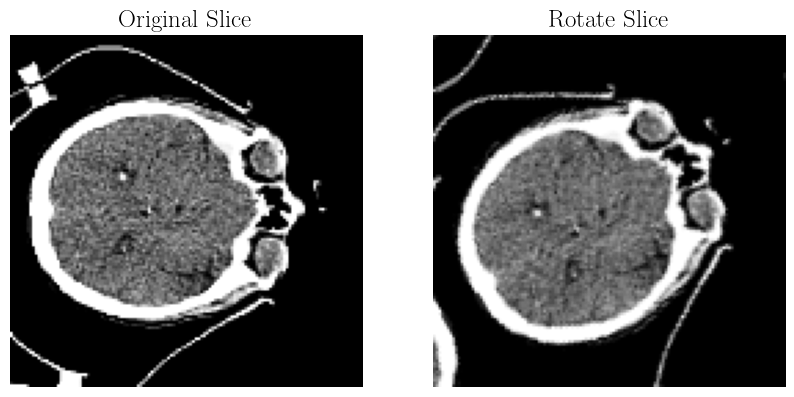

Crop Shape: (128, 128, 64)


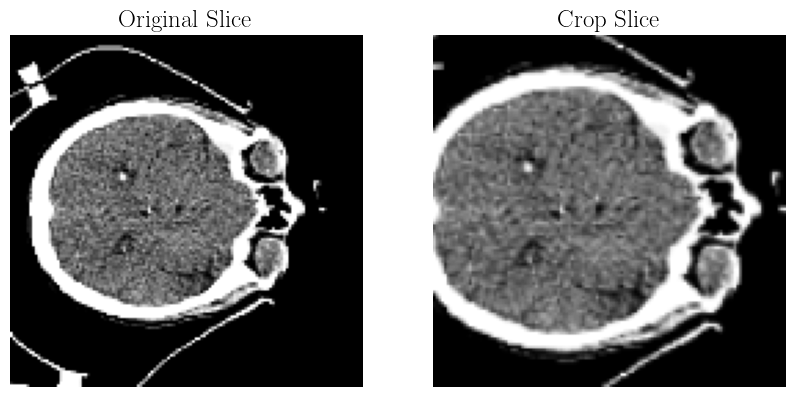

Flip Shape: (128, 128, 64)


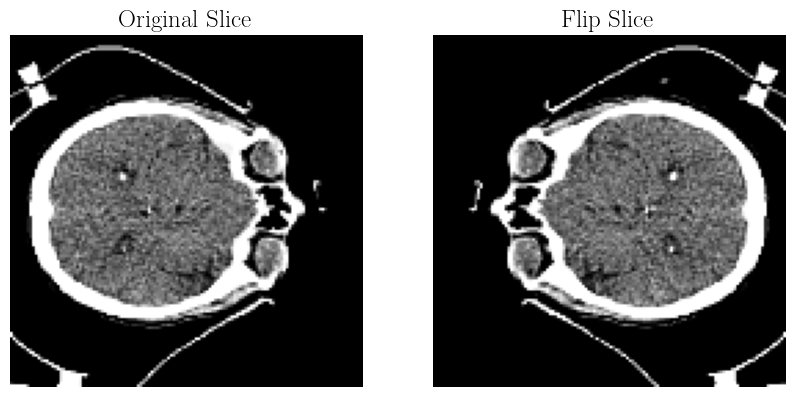

Intensity Shape: (128, 128, 64)


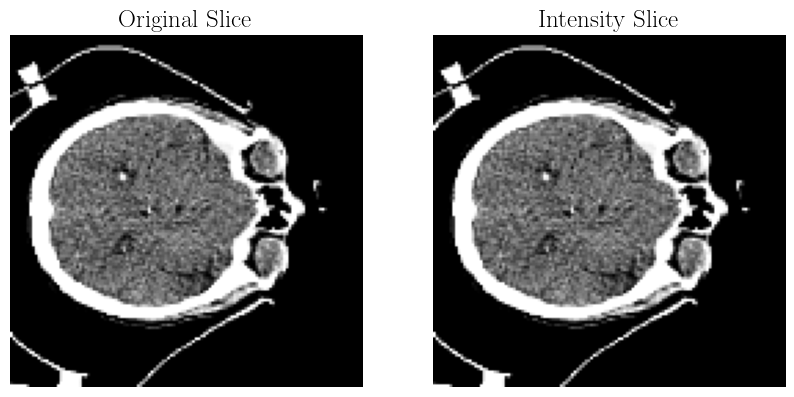

In [14]:
plot.visualize_augmentation(normalized_image, augmented_Rotate, slice_index=32, name='Rotate')
plot.visualize_augmentation(normalized_image, augmented_Crop, slice_index=32, name='Crop')
plot.visualize_augmentation(normalized_image, augmented_Flip, slice_index=32, name='Flip')
plot.visualize_augmentation(normalized_image, augmented_intensity, slice_index=32, name='Intensity')


#### Predict T1w image from CT input

In [15]:
m1= trained_modelTA.predict(tf.expand_dims(augmented_Rotate, axis=0))
m2= trained_modelTA.predict(tf.expand_dims(np.squeeze(augmented_Crop), axis=0))
m3= trained_modelTA.predict(tf.expand_dims(augmented_Flip, axis=0))
m4= trained_modelTA.predict(tf.expand_dims(augmented_intensity, axis=0))
m5= trained_modelTA.predict(tf.expand_dims(input_tensor, axis=0))

1/1 [==============================] - 23s 23s/step


In [16]:
def extract_first_output(pred):
    if isinstance(pred, dict):
        return next(iter(pred.values()))
    return pred

pred_list = [extract_first_output(x) for x in [m1, m2, m3, m4, m5]]


#### Show the predicted image, Heatmap,Histogram of Pixel difference

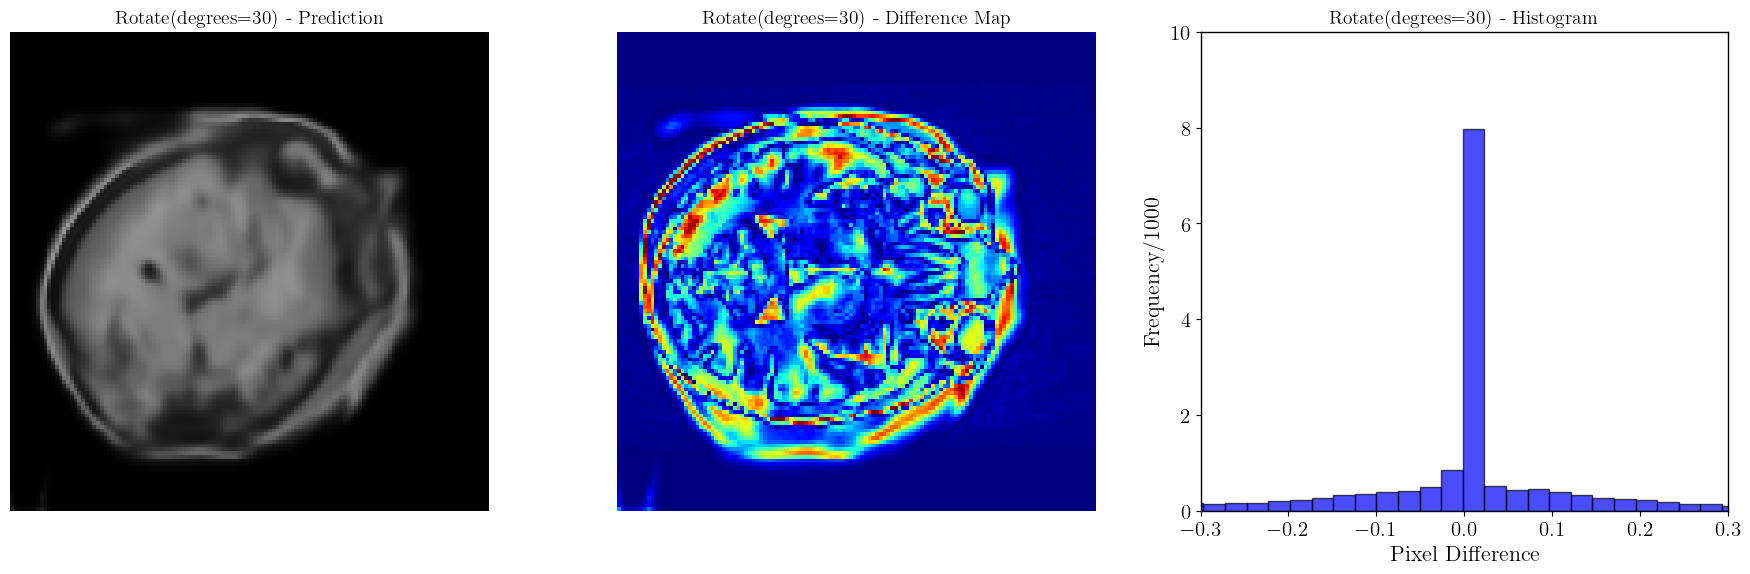

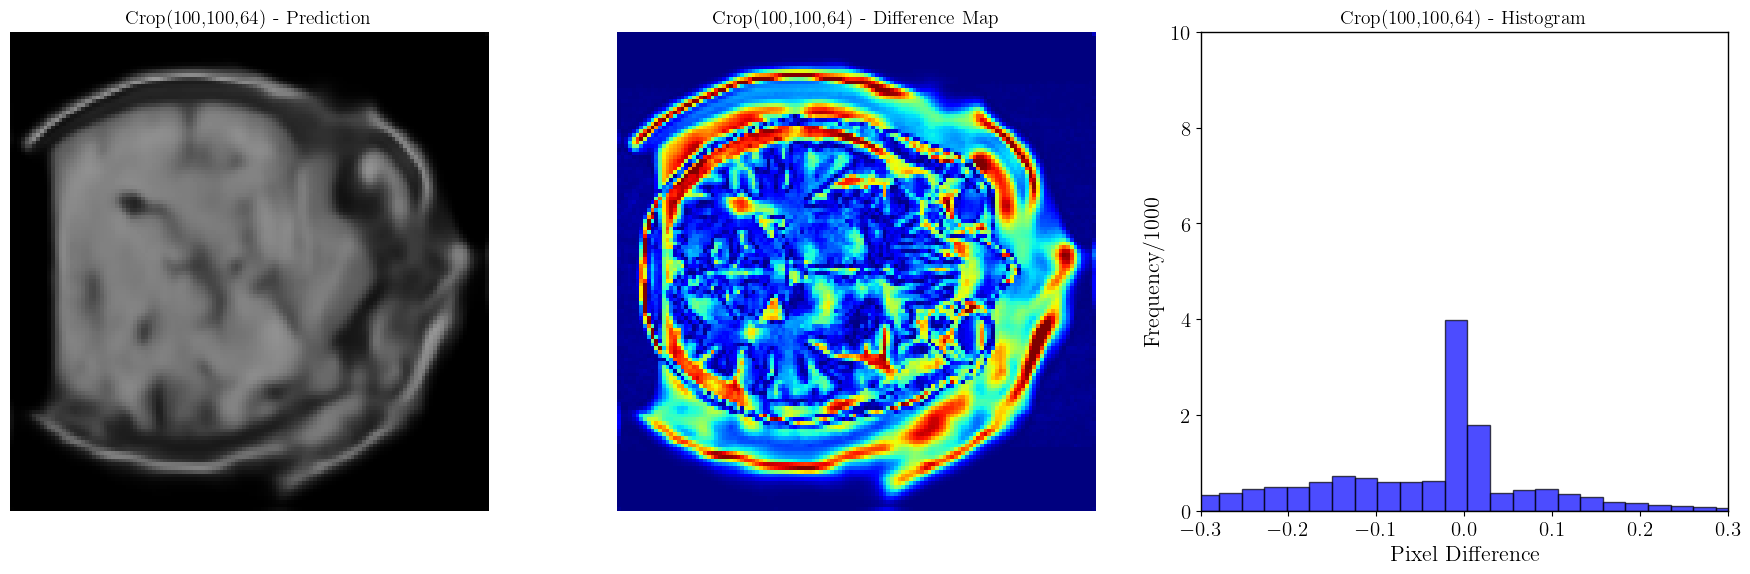

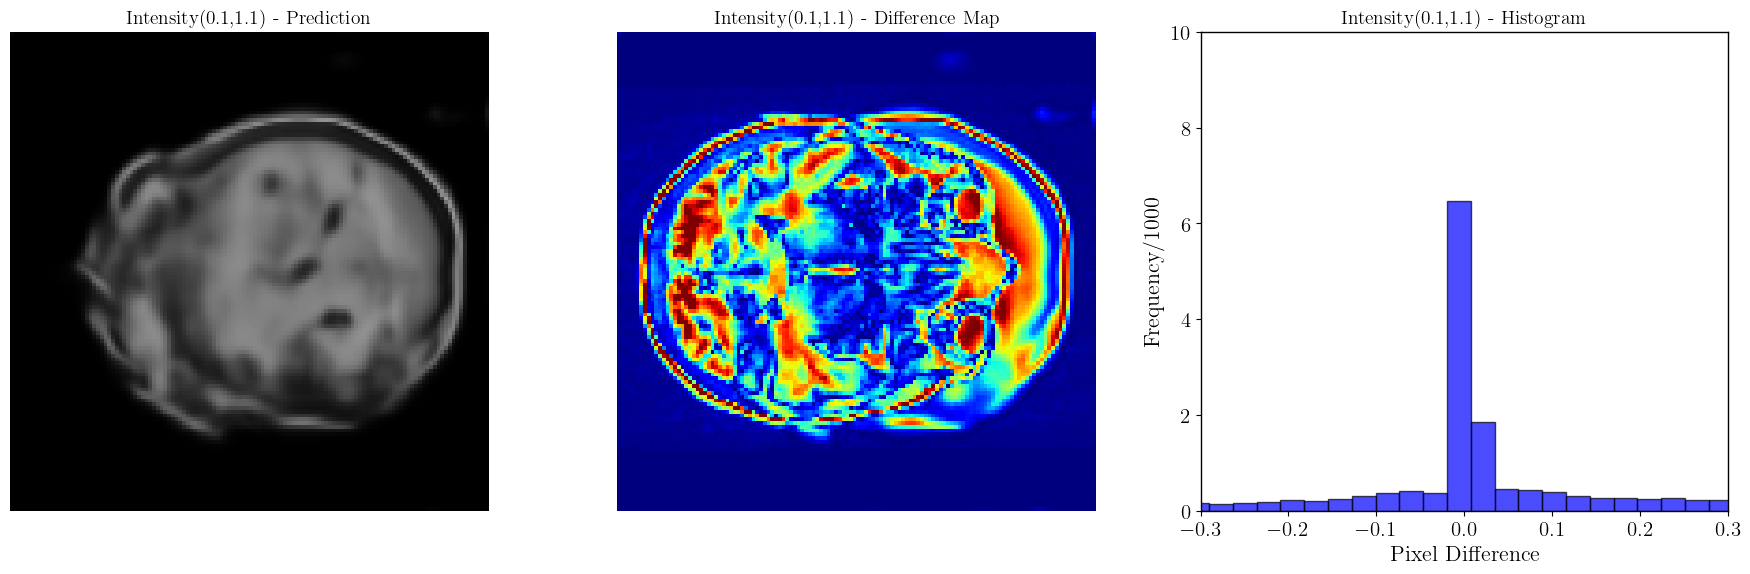

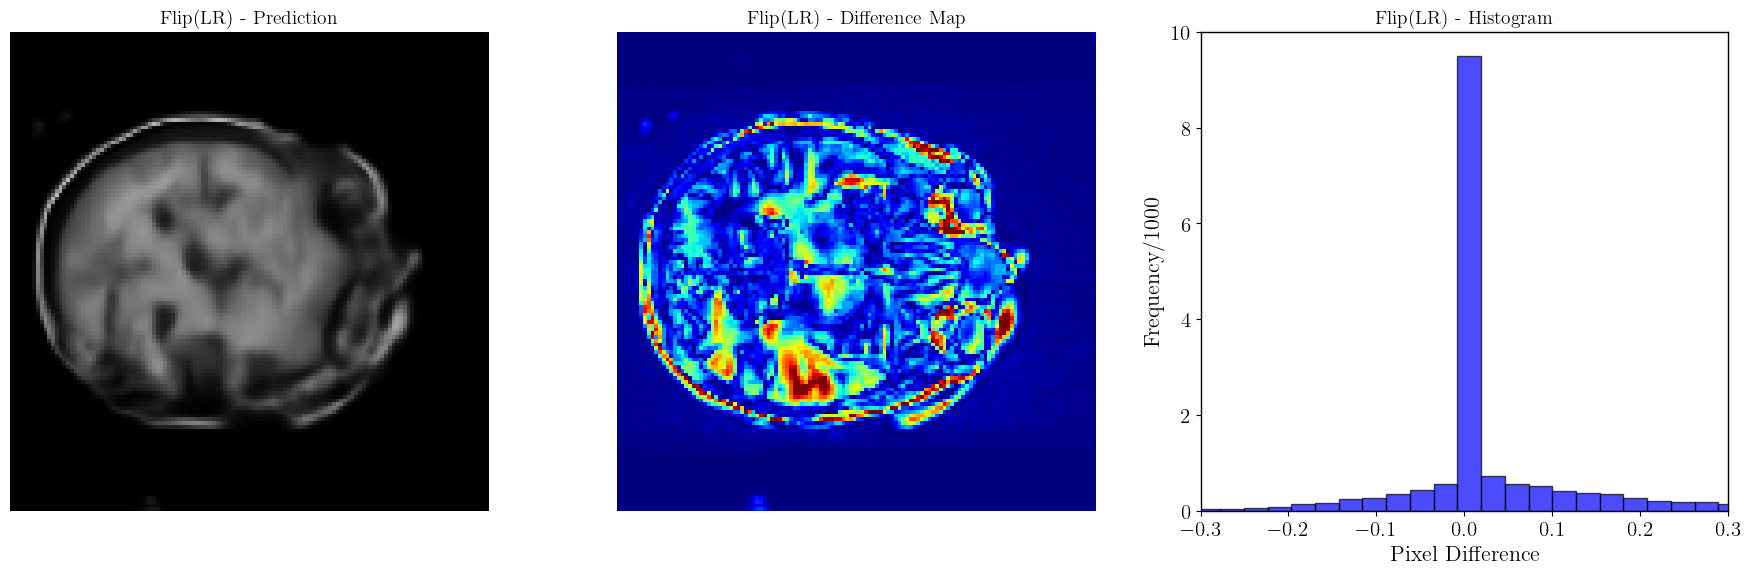

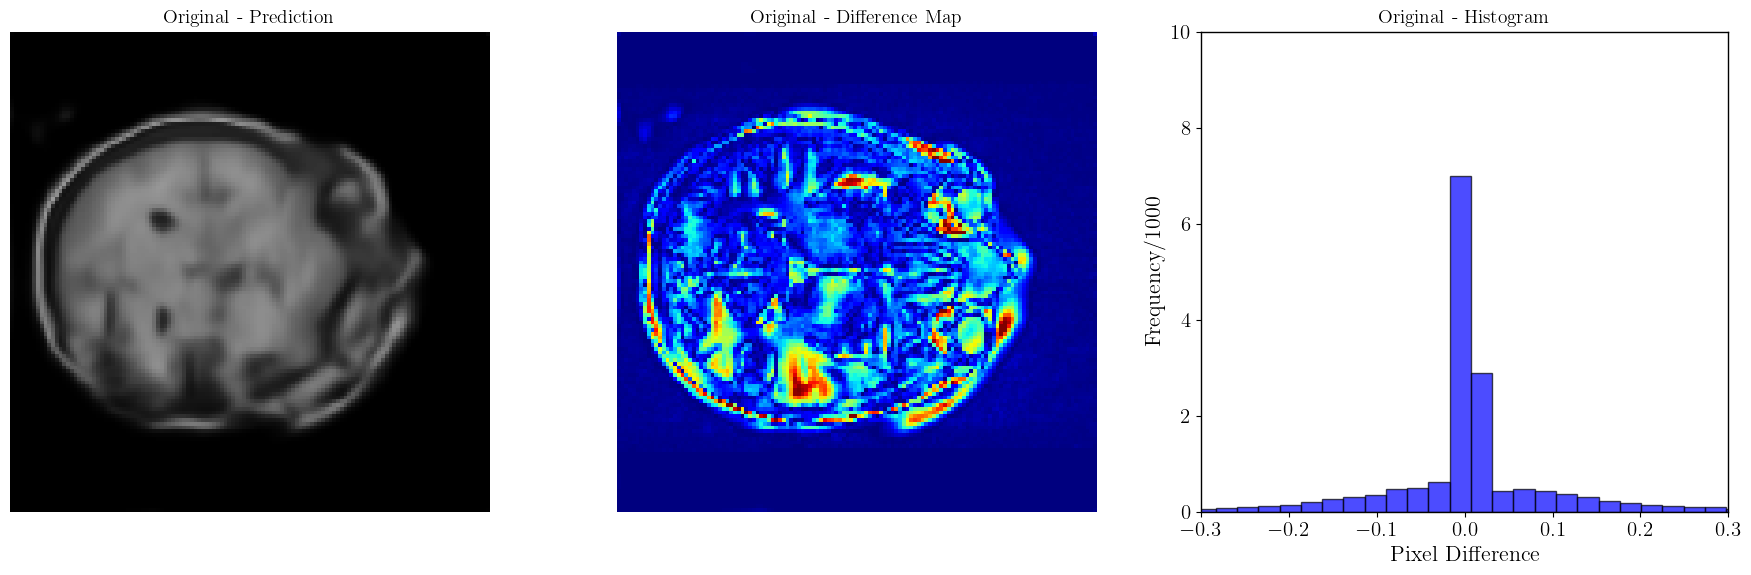

In [17]:
pred_names = ['Rotate(degrees=30)', 'Crop(100,100,64)', 'Intensity(0.1,1.1)', 'Flip(LR)', 'Original']
plot.visualize_predictions_with_difference(pred_list, pred_names, ground_truth, normalized_image, batch_index=0)


#### Performance assessment

In [19]:
# pred_list = [m1, m2, m3, m4, m5]
pred_names = ['Rotate(degrees=30)', 'Crop(100,100,64)', 'Intensity(0.1,1.1)', 'Flip(LR)', 'Original']

psnr_scores, ssim_scores = utils.compute_psnr_ssim(
    predictions=pred_list,
    prediction_names=pred_names,
    ground_truth=ground_truth,
    original_image=normalized_image,
    batch_index=0,
    save_dir='results/figures',    
    visualize=False                
)

# Print Summary Table
print("\nSummary of PSNR and SSIM Scores:\n")
print("{:<25} {:<10} {:<10}".format("Prediction", "PSNR", "SSIM"))
print("-" * 45)
for name, p_val, s_val in zip(pred_names, psnr_scores, ssim_scores):
    print("{:<25} {:<10.4f} {:<10.4f}".format(name, p_val, s_val))



Summary of PSNR and SSIM Scores:

Prediction                PSNR       SSIM      
---------------------------------------------
Rotate(degrees=30)        17.2051    0.3806    
Crop(100,100,64)          14.6794    0.2174    
Intensity(0.1,1.1)        14.6689    0.3496    
Flip(LR)                  18.3987    0.5312    
Original                  19.4303    0.5543    
